**Contexte et Objectif**

L’objectif de cette étude est de déterminer la hauteur optimale de la digue en prenant en compte trois composantes essentielles :

- Le coût d’investissement et de maintenance
- Le coût des dommages liés aux inondations
- Les incertitudes hydrauliques
  
Cette approche se distingue des précédentes en intégrant explicitement l’aspect économique dans la prise de décision. Contrairement à l’approche historique, qui analyse les crues passées, et à l’approche hydraulique, qui vise à minimiser le risque de surverse seulement, nous cherchons ici à minimiser le coût total moyen annuel sur 30 ans en équilibrant protection et viabilité économique.

**Modélisation des Coûts**

Le coût total de la digue est composé de deux éléments :

- $C_t(T)$ : Coût total d’investissement et de maintenance sur 30 ans
- $C_d$ :  le coût total de dommage (pour une année)
  
L’objectif est de minimiser le coût moyen annuel :

$$𝐶_{𝑐,moyenne} = C_t(T) + \sum_{j=1}^T C_{d,j}(S_j,h_d)$$
​
 
Avec :

- Coût d’investissement et maintenance :

$C_t(T)=C_i(h_d)+T.C_m(h_d)$ sur la durée T

où $C_i(h_d)$ est le coût initial de construction et $C_m(h_d) = 0.01.C_i$ est le coût annuel de maintenance (fixé à 1% du coût initial).

- Coût des dommages en cas de surverse :

$C_d = C_s +C_g =C_s(S)+C_g(S,h_d)$ sur une année 

où $C_s(S)$ est le coût des dommages aux infrastructures et $C_g(S,h_d)$ est le coût des réparations de la digue après une inondation.

L’idée est donc de trouver la hauteur de digue $h_d$ qui minimise ce coût total.

**Prise en Compte des Incertitudes et Simulation Monte-Carlo**

Les inondations et leurs impacts économiques étant soumis à de fortes incertitudes, nous utilisons une simulation Monte-Carlo pour modéliser les crues et les dommages sur une longue période.

Les variables hydrauliques sont générées selon des lois de probabilité adaptées comme dans l'approche 2.
Nous réalisons 10 000 simulations pour 30 années différentes, ce qui permet d’estimer une distribution réaliste des hauteurs de crue et des coûts économiques associés.

**Pourquoi utiliser Monte-Carlo dans cette approche**

Tout comme dans l’approche 2, cette méthode repose sur le modèle hydraulique des crues, qui est soumis à d’importantes incertitudes liées aux conditions naturelles. Il est donc essentiel de prendre en compte ces variabilités aléatoires pour obtenir une estimation réaliste des hauteurs d’eau et des risques de surverse.

L’utilisation de la simulation Monte-Carlo permet de modéliser ces incertitudes de manière robuste, en générant un grand nombre de scénarios possibles afin de représenter l’ensemble des configurations hydrauliques possibles sur la période étudiée. En particulier, elle est bien adaptée à la prise en compte des événements extrêmes et des incertitudes, ce qui est fondamental dans ce cadre.

Par rapport à d’autres méthodes d’optimisation, la simulation Monte-Carlo présente plusieurs avantages :
Robustesse : Elle permet de modéliser précisément les risques associés aux inondations.
Flexibilité : Elle permet d’intégrer des distributions de probabilité adaptées aux variables hydrauliques et économiques.
Simplicité de mise en œuvre : Contrairement aux approches analytiques classiques, elle ne nécessite pas d’hypothèses simplificatrices sur la distribution et permet une meilleure prise en compte des incertitudes réelles.

**Interpolation**

L’interpolation est une technique essentielle dans cette approche, utilisée à deux niveaux distincts :

- Interpolation des coûts de dommages
Les valeurs de surverse S obtenues à partir des simulations Monte-Carlo ne correspondent pas nécessairement aux hauteurs de surverse définies dans le tableau des coûts économiques. our estimer les coûts des dommages au site $C_s$ et à la digue $c_g$ pour n’importe quelle valeur de S, nous utilisons une interpolation linéaire.


- Interpolation pour l’optimisation de la hauteur de la digue
  
Les hauteurs de digue disponibles dans le fichier Excel sont discrètes. Or, la hauteur optimale ne correspond pas forcément à l’une de ces valeurs.
Pour affiner la recherche de la hauteur qui minimise le coût total moyen, nous utilisons une interpolation cubique avec interp1d().
Cette interpolation est intéressante car elle transforme la relation entre la hauteur de digue et le coût en une fonction continue, permettant une recherche plus fine du minimum et permet d’estimer une hauteur optimale plus réaliste sans être contraint par les valeurs discrètes du tableau initial.


C:\Users\ouaha\AppData\Local\Temp\ipykernel_22288\1392717193.py:55: RuntimeWarning: invalid value encountered in power
  H = (Q / (Ks * np.sqrt((Zm - Zv) / L) * B))**(3/5)


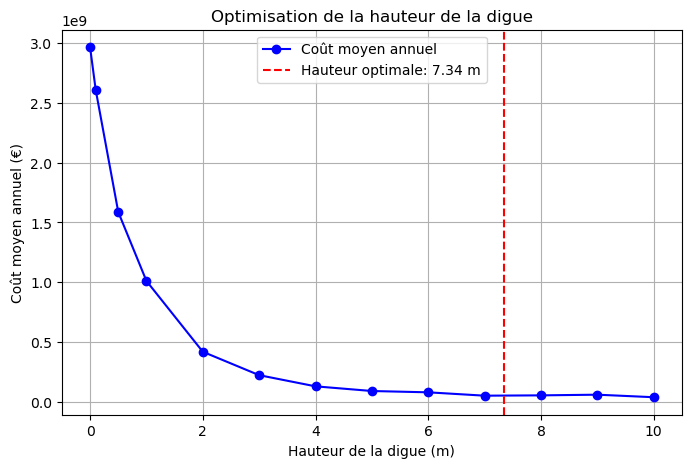

Hauteur optimale de la digue: 7.34 m


In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# 🔹 Charger le fichier Excel
file_path = "Données-Projet-Pratique-Fiabilité.xlsx"
xls = pd.ExcelFile(file_path)

# 🔹 Lire la deuxième feuille contenant les deux tableaux
df_economie = pd.read_excel(xls, sheet_name=xls.sheet_names[1], header=None)

# 🔹 Identifier la séparation des tableaux
sep_index = df_economie[df_economie[0] == "Coûts des dommages liés à la surverse"].index[0]

# 🔹 Extraire le premier tableau (coût de la digue)
df_digue = df_economie.iloc[1:sep_index, :].dropna(how="all")
df_digue.columns = ["Hauteur de la digue (m)", "Coût du linéaire (€/m)", "Longueur de la digue (m)", "Coût total d’investissement (k€)"]
df_digue = df_digue.iloc[1:].reset_index(drop=True)

# 🔹 Extraire le second tableau (coût des dommages)
df_dommages = df_economie.iloc[sep_index+2:, :].dropna(how="all")
df_dommages = df_dommages.dropna(axis=1, how='all')
df_dommages.columns = ["Hauteur de la surverse (m)", "Coût des dommages au site (M€)", "Coût des dommages à la digue (%)"]
df_dommages["Hauteur de la surverse (m)"] = df_dommages["Hauteur de la surverse (m)"].replace(">2", 2.1).astype(float)

# 🔹 Convertir en tableaux exploitables
hauteurs_digue = df_digue["Hauteur de la digue (m)"].astype(float).values
Ci_values = df_digue["Coût total d’investissement (k€)"].astype(float).values * 1000
Cm_values = 0.01 * Ci_values

hauteurs_surverse = df_dommages["Hauteur de la surverse (m)"].values
C_s_values = df_dommages["Coût des dommages au site (M€)"].astype(float).values * 1e6
C_g_percent = df_dommages["Coût des dommages à la digue (%)"].astype(float).values / 100

# 🔹 Paramètres du modèle
T = 30
n_simulations = 10000
L, B, Zb = 5000, 300, 55.5  


# 🔹 Fonctions pour générer les échantillons
def generate_samples(n):
    return (
        np.random.gumbel(1013, 558, n),
        np.random.normal(30, 7.5, n),
        np.random.triangular(49, 50, 51, n),
        np.random.triangular(54, 55, 56, n),
    )

# 🔹 Fonction pour calculer H et S
def calc_hydraulique(Q, Ks, Zv, Zm, h_d):
    H = (Q / (Ks * np.sqrt((Zm - Zv) / L) * B))**(3/5)
    S = S = np.maximum(Zv + H - h_d - Zb, 0)
    return S

# 🔹 Fonction coût de dommage
def C_dommage(S, Ci):
    return (
        np.interp(S, hauteurs_surverse, C_s_values),
        np.interp(S, hauteurs_surverse, C_g_percent) * Ci,
    )

# 🔹 Optimisation de la hauteur de la digue
Cc_moyenne = []

for h_d, Ci, Cm in zip(hauteurs_digue, Ci_values, Cm_values):
    Ct_T = Ci + (T * Cm)  
    
    # Génération des échantillons
    Q_sim, Ks_sim, Zv_sim, Zm_sim = generate_samples(n_simulations * T)
    Q_sim, Ks_sim, Zv_sim, Zm_sim = [x.reshape(T, -1) for x in (Q_sim, Ks_sim, Zv_sim, Zm_sim)]
    
    # Calcul de S
    S_sim = calc_hydraulique(Q_sim, Ks_sim, Zv_sim, Zm_sim, h_d)
    S_sim = S_sim[~np.isnan(S_sim)]
    
    # Coût des dommages 
    C_s_sim, C_g_sim = C_dommage(S_sim, Ci)
    Cd_T = np.sum(C_s_sim + C_g_sim) / T  
    
    # Coût total moyen
    Cc_moyenne.append((Ct_T + Cd_T) / T)  

# 🔹 Recherche de la hauteur optimale
interp_func = interp1d(hauteurs_digue[:len(Cc_moyenne)], Cc_moyenne, kind='cubic')
res = minimize_scalar(interp_func, bounds=(min(hauteurs_digue), max(hauteurs_digue)), method='bounded')
h_d_optimal = res.x


# 🔹 Affichage des résultats
plt.figure(figsize=(8, 5))
plt.plot(hauteurs_digue[:len(Cc_moyenne)], Cc_moyenne, label="Coût moyen annuel", color='b', marker='o')
if h_d_optimal:
    plt.axvline(h_d_optimal, color='r', linestyle="--", label=f"Hauteur optimale: {h_d_optimal:.2f} m")
plt.xlabel("Hauteur de la digue (m)")
plt.ylabel("Coût moyen annuel (€)")
plt.legend()
plt.title("Optimisation de la hauteur de la digue")
plt.grid(True)
plt.show()

print(f"Hauteur optimale de la digue: {h_d_optimal:.2f} m")



Enfin, afin d’évaluer l’incertitude sur , nous calculons un intervalle de confiance (IC) à 95% en utilisant une approche bootstrap Monte Carlo. L’IC est donné par la formule :
$$IC(h_d) = h_d \pm z_{\alpha/2} \cdot \frac{\sigma_{h_d}}{\sqrt{n}}$$
où  est l’écart-type des hauteurs optimales obtenues par simulation.

Cette approche permet de quantifier la variabilité de l’optimisation, en évitant de se baser uniquement sur une valeur unique de $h_d$ .

In [10]:
from scipy.stats import norm
n_bootstrap = 1000
h_d_bootstrap = []

for _ in range(n_bootstrap):
    sample_indices = np.random.choice(len(hauteurs_digue[:len(Cc_moyenne)]), size=len(Cc_moyenne), replace=True)
    Cc_sample = np.array(Cc_moyenne)[sample_indices]
    
    interp_func_sample = interp1d(hauteurs_digue[:len(Cc_sample)], Cc_sample, kind='cubic')
    res_sample = minimize_scalar(interp_func_sample, bounds=(min(hauteurs_digue), max(hauteurs_digue)), method='bounded')
    
    h_d_bootstrap.append(res_sample.x)

# 🔹 Calcul des IC à 95%
z_alpha = norm.ppf(0.975)  # 1.96 pour IC à 95%
sigma_h_d = np.std(h_d_bootstrap)
IC_h_d_lower = h_d_optimal - z_alpha * sigma_h_d / np.sqrt(n_bootstrap)
IC_h_d_upper = h_d_optimal + z_alpha * sigma_h_d / np.sqrt(n_bootstrap)

In [11]:
print(f"Hauteur optimale de la digue: {h_d_optimal:.2f} m")
print(f"IC à 95% pour h_d optimal : [{IC_h_d_lower:.2f} m ; {IC_h_d_upper:.2f} m]")

Hauteur optimale de la digue: 7.34 m
IC à 95% pour h_d optimal : [7.22 m ; 7.46 m]


L’IC est relativement étroit, ce qui indique une faible incertitude sur $hd$ .
La hauteur optimale de 7.34 m équilibre coût et sécurité, évitant un surdimensionnement excessif.
L’optimisation économique réduit les coûts inutiles tout en garantissant une protection efficace.


L’intégration d’un modèle économique à l’analyse hydraulique permet d’optimiser la hauteur de la digue en minimisant son coût total tout en assurant une protection suffisante. La simulation de Monte Carlo garantit une prise en compte rigoureuse des incertitudes, tandis que l’interpolation cubique affine la recherche de l’optimum.
L’ajout d’un intervalle de confiance renforce la robustesse des résultats et permet une prise de décision plus éclairée, en intégrant explicitement l’incertitude liée à l’estimation de $h_d$.


###  Résumé des Résultats

| **Approche**  | **Méthode utilisée**                                    | **Hauteur optimale \( h_d \)** | **Intervalle de confiance (IC)**       | **Avantages**                                     | **Inconvénients**                                  |
|--------------|------------------------------------------------|------------------|--------------------------------|------------------------------------------------|------------------------------------------------|
| **Approche 1** | Quantile empirique avec régression linéaire   | **6.36 m (Q95)** <br> **7.37 m (Q99)** | **[5.95 m ; 6.77 m]** (Q95) <br> **[6.66 m ; 7.92 m]** (Q99) | Simple et rapide <br> Utilisation des données observées | Ne prend pas en compte l’incertitude des valeurs manquantes |
| **Approche 2** | Simulation Monte Carlo (hydraulique)          | **7.60 m**       | **[7.52 m ; 7.68 m]**          | Prend en compte l’incertitude des variables hydrauliques | Ne considère pas les coûts économiques           |
| **Approche 3** | Simulation Monte Carlo (hydraulique + économique) + interpolation cubique | **7.34 m**       | **[7.22 m ; 7.45 m]**          | Optimise à la fois la sécurité et le coût <br> Prise en compte des incertitudes hydrauliques et économiques | Calcul plus complexe nécessitant une estimation fiable des coûts |


**Analyse des Approches**
1) L’Approche 1 (quantile empirique avec régression linéaire) repose sur l’analyse directe des valeurs observées et la régression linéaire pour combler les données manquantes. Cette méthode est simple et rapide mais présente une limite importante : elle ne tient pas compte des incertitudes associées aux hauteurs d’eau futures. De plus, elle ne permet pas d’évaluer les risques économiques liés aux surverses.

2) L’Approche 2 (Monte Carlo appliqué à l’hydraulique) améliore la robustesse de l’estimation de $h_d$ en prenant en compte l’incertitude des variables hydrauliques. Elle permet d’obtenir une hauteur plus sécurisée (7.60 m), tout en fournissant un intervalle de confiance fiable. Toutefois, cette approche ne prend pas en compte les aspects économiques, ce qui peut conduire à un dimensionnement excessif de la digue.

3) L’Approche 3 (Monte Carlo appliqué à l’hydraulique et à l’économie) apporte un compromis optimal entre sécurité et coût. En intégrant les coûts de construction et d’entretien, elle permet d’optimiser la hauteur de la digue tout en évitant des dépenses excessives. La hauteur optimale obtenue est 7.34 m, avec un intervalle de confiance plus serré que celui de l’Approche 2. Cette approche est plus réaliste car elle reflète les contraintes financières et hydrauliques.



**Choix Final Justifié**

Après comparaison, l’Approche 3 est la plus pertinente, car elle permet :
Une prise en compte complète des incertitudes hydrauliques et économiques, ce qui garantit une solution équilibrée.
Une optimisation des coûts, évitant un surdimensionnement inutile de la digue tout en assurant une protection efficace.
Une estimation plus fiable avec un IC plus étroit, réduisant l’incertitude sur $h_d$